In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from transformers import GPT2Model, GPT2Config
import skimage as sk
import random

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

to_numpy = lambda x: x.detach().cpu().numpy()

cuda:1


Files already downloaded and verified


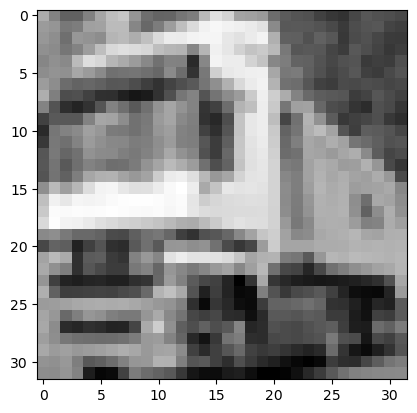

In [2]:
cifar = torchvision.datasets.CIFAR10(download=True, root='.')
cifar = cifar.data.transpose((0, 3, 1 ,2)).mean(1, keepdims=True)
plt.imshow(cifar[1, 0], cmap='gray')
cifar_mini = sk.transform.rescale(cifar, 0.25)

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, image_size=8, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.h_embed = nn.Parameter(torch.randn(1, embed_dim, self.grid_h, 1))
        self.w_embed = nn.Parameter(torch.randn(1, embed_dim, 1, self.grid_w))

    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x + self.h_embed + self.w_embed
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        return x

class PositionalEmbedding(nn.Module):
    # from https://discuss.pytorch.org/t/transformer-positional-encoding-class/159168
    def __init__(self, max_seq_len, embed_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = np.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
        # make embeddings relatively larger
        x = x * np.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.as_tensor(self.pe[:, :seq_len]).to(x.device)
        return x

class SinusoidalPatchEmbed(nn.Module):
    def __init__(self, image_size=8, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.embeds = PositionalEmbedding((image_size // patch_size) ** 2, embed_dim)
        
    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        x = self.embeds(x)
        return x

class SimpleViT(nn.Module):
    def __init__(self, image_size=8, patch_size=2, embed_dim=256, num_layers=4, nhead=4):
        super().__init__()
        self.patch_embed = PatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, T, -1)
        return embeddings

class SimplerViT(nn.Module):
    def __init__(self, image_size=8, patch_size=2, embed_dim=256, output=1, num_layers=1, nhead=1):
        super().__init__()
        self.patch_embed = SinusoidalPatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)
        self.out_linear = nn.Linear(embed_dim, output)

    def forward(self, x):
        B, C, H, W = x.shape
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, -1)
        out = self.out_linear(embeddings)
        return out

class MiniResnet(nn.Module):
    def __init__(self, image_size=8, embed_dim=256, num_layers=8):
        super().__init__()
        self.input_conv = nn.Conv2d(1, 32, 3, 1, 1)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(nn.Conv2d(32, 32, 3, 1, 1))
        self.output = nn.Linear(image_size**2 *32, embed_dim)
    
    def forward(self, x):
        x = F.relu(self.input_conv(x))
        for layer in self.convs:
            x = F.relu(layer(x)) + x
        x = x.flatten(1)
        x = self.output(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, image_size=8, embed_dim=1, num_convs=1, num_channels=1, patch_size=2):
        # Let's just do x convs followed by a single linear layer
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(nn.Conv2d(1, num_channels, kernel_size=patch_size, stride=patch_size, bias=False))
        for i in range(num_convs - 1):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size=patch_size, padding='same', bias=False))
        self.conv_size = num_channels * (image_size * image_size) // (patch_size * patch_size)
        self.linear = nn.Linear(self.conv_size, embed_dim, bias=False)
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = F.relu(conv(x))
        x = x.flatten(1)
        x = self.linear(x)
        return x
    
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight)

class SimpleMLP(nn.Module):
    def __init__(self, image_size=8, embed_dim=1, hidden_dim=100, num_hidden=0):
        super().__init__()
        self.input_size = image_size ** 2
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, hidden_dim, bias=False))
        for _ in range(num_hidden):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
        self.output_layer = nn.Linear(hidden_dim, embed_dim, bias=False)
        self._initialize_weights()
        
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)
        
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if i < len(layers) - 1:
                    nn.init.normal_(m.weight)
                else:
                    nn.init.normal_(m.weight, std=2/self.hidden_dim)

class VisionICLTransformer(nn.Module):
    def __init__(self, val_dim=1, embed_dim=256, num_heads=8, num_layers=12, vit_heads=2, vit_layers=8,
                 image_size=8, patch_size=2, max_seq_len=128):
        # max_seq_len corresponds to 2k, so k x_k samples and k f(x_k), and then one more for x_query
        super().__init__()

        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.num_patches = self.grid_h * self.grid_w

        self.time_embed = nn.Parameter(torch.randn(1, max_seq_len * 2, embed_dim))

        self.val_dim = val_dim
        self.value_proj = nn.Linear(val_dim, embed_dim)

        self.vit = SimpleViT(image_size, patch_size, embed_dim, vit_layers, vit_heads)
        self.cnn = MiniResnet(image_size, embed_dim=embed_dim)
        
        config = GPT2Config(
            n_positions=2 * max_seq_len,
            n_embd=embed_dim,
            n_layer=num_layers,
            n_head=num_heads,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.transformer = GPT2Model(config)

        self.fc_out = nn.Linear(embed_dim, val_dim)

    def forward(self, images, values, use_vit=True):
        B, T, C, H, W = images.shape
        B, T, _ = values.shape

        if use_vit:
            img_embeddings = self.vit(images)
        else:
            images = images.reshape(-1, *images.shape[2:])
            img_embeddings = self.cnn(images)
            img_embeddings = img_embeddings.reshape(B, T, -1)

        inds = torch.arange(T).to(device)

        val_embeds = self.value_proj(values)

        embeddings = self.interleave(img_embeddings, val_embeds)

        x = self.transformer(inputs_embeds=embeddings).last_hidden_state
        predictions = self.fc_out(x)

        return predictions[:, ::2, 0][:, inds]
    
    def interleave(self, xs, ys):
        B, T, D = xs.shape
        stacked = torch.stack((xs, ys), dim=2)  # [B, T, 2, D]
        interleaved = stacked.view(B, 2 * T, D)
        return interleaved

In [4]:
def sample_cifar_mini(n, flatten=False):
    indices = torch.randint(0, cifar_mini.shape[0], (n,))
    if flatten:
        images = cifar_mini[indices].reshape(n, -1)
    else:
        images = cifar_mini[indices].reshape(n, *cifar_mini.shape[1:])
    images = (images - cifar_mini.mean()) / (cifar_mini.std() + 1e-8)
    images = torch.tensor(images).float()
    return images

In [5]:
model1 = VisionICLTransformer()
model2 = VisionICLTransformer(patch_size=4, vit_layers=4)
model3 = VisionICLTransformer(patch_size=4, vit_layers=4)
model4 = VisionICLTransformer(patch_size=4, vit_layers=12)
model1.load_state_dict(torch.load('exp1_model.pt', map_location=device))
model1 = model1.to(device)
model2.load_state_dict(torch.load('exp2_model.pt', map_location=device))
model2 = model2.to(device)
model3.load_state_dict(torch.load('exp3_model.pt', map_location=device))
model3 = model3.to(device)
model4.load_state_dict(torch.load('exp4_model.pt', map_location=device))
model4 = model4.to(device)

In [6]:
def generate_linear_task(n, input_dim=64):
    w = torch.randn(input_dim)

    x_ctx = sample_cifar_mini(n, flatten=True)
    y_ctx = x_ctx @ w.view(-1, 1)

    x_query = sample_cifar_mini(1, flatten=True)
    y_true = x_query @ w.view(-1, 1)

    return x_ctx, y_ctx, x_query, y_true

In [11]:
def make_transformer_input(x_ctx, y_ctx, x_query, image_size=8):
    x_input = torch.cat([x_ctx, x_query])
    x_input = x_input.view(1, -1, 1, image_size, image_size)
    y_input = torch.cat([y_ctx, torch.zeros(1, 1)]).view(1, -1, 1)

    return x_input, y_input

errors = {"TransformerCNN": [], "TransformerViT": [], "Least Squares": [], "3-NN": [], "Averaging": []}

max_context = 100
average_over = 32

for n in range(1, max_context):
    err_t1 = err_t2 = err_ls = err_knn = err_avg = 0
    for _ in range(average_over):
        x_ctx, y_ctx, x_query, y_true = generate_linear_task(n)

        x_input, y_input = make_transformer_input(x_ctx, y_ctx, x_query)
        x_input = x_input.to(device)
        y_input = y_input.to(device)

        with torch.no_grad():
            y_pred1 = model1(x_input, y_input, use_vit=False)
            y_pred2 = model2(x_input, y_input)

        err_t1 += ((y_pred1.squeeze()[-1] - y_true.to(device)) ** 2).item()
        err_t2 += ((y_pred2.squeeze()[-1] - y_true.to(device)) ** 2).item()
        
        X = torch.cat([x_ctx, torch.ones_like(x_ctx)], dim=0)
        res = torch.linalg.lstsq(x_ctx, y_ctx)
        beta = res.solution
        y_ls = x_query @ beta
        err_ls += ((y_ls - y_true) ** 2).item()

        dists = torch.abs(x_ctx - x_query)
        _, idxs = torch.topk(dists, min(3, len(x_ctx)), largest=False, dim=0)
        y_knn = y_ctx[idxs].mean()
        err_knn += ((y_knn - y_true)**2).item()

        y_avg = y_ctx.mean()
        err_avg += ((y_avg - y_true)**2).item()

    errors["TransformerCNN"].append(err_t1 / average_over)
    errors["TransformerViT"].append(err_t2 / average_over)
    errors["Least Squares"].append(err_ls / average_over)
    errors["3-NN"].append(err_knn / average_over)
    errors["Averaging"].append(err_avg / average_over)


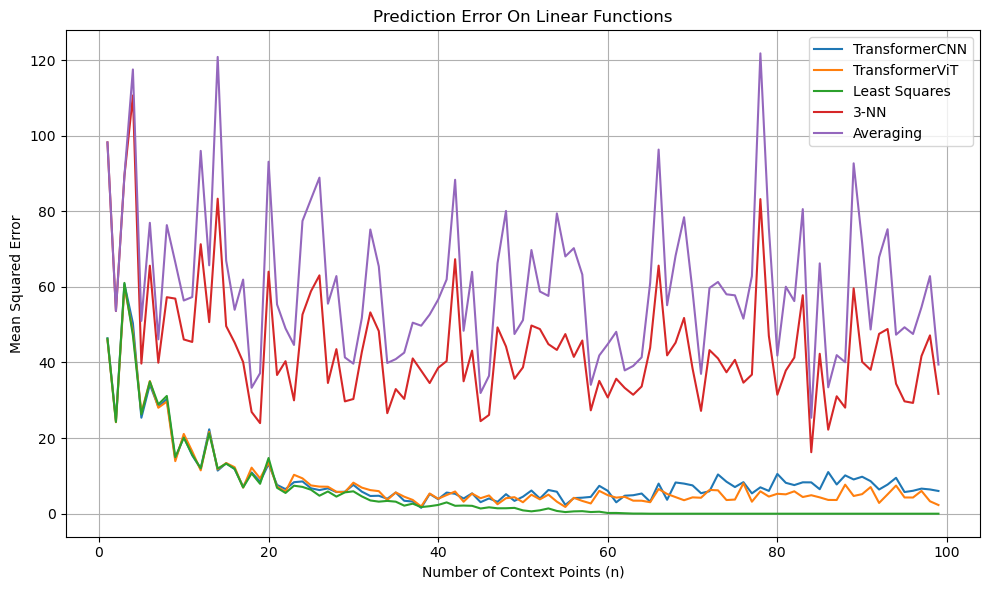

In [12]:
import matplotlib.pyplot as plt

n_vals = list(range(1, max_context))

plt.figure(figsize=(10, 6))
for method, err_list in errors.items():
    plt.plot(n_vals, err_list, label=method)

plt.title("Prediction Error On Linear Functions")
plt.xlabel("Number of Context Points (n)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
def generate_simple_conv_task(n, image_size=8, kernel_size=3):
    w = torch.randn(image_size ** 2)
    kernel = nn.Conv2d(1, 1, kernel_size, padding='same', bias=None) 
    nn.init.orthogonal_(kernel.weight)
    
    x_ctx = sample_cifar_mini(n)
    temp = kernel(x_ctx).flatten(1)
    y_ctx = temp @ w.view(-1, 1)

    x_query = sample_cifar_mini(1)
    temp = kernel(x_query).flatten(1)
    y_true = temp @ w.view(-1, 1)

    return x_ctx.view(-1, image_size ** 2), y_ctx, x_query.view(-1, image_size ** 2), y_true

In [22]:
errors = {"TransformerCNN": [], "TransformerViT": [], "Least Squares": [], "3-NN": [], "Averaging": []}

max_context = 100
average_over = 32

for n in range(1, max_context):
    err_t1 = err_t2 = err_ls = err_knn = err_avg = 0
    for _ in range(average_over):
        x_ctx, y_ctx, x_query, y_true = generate_simple_conv_task(n)

        x_input, y_input = make_transformer_input(x_ctx, y_ctx, x_query)
        x_input = x_input.to(device)
        y_input = y_input.to(device)

        with torch.no_grad():
            y_pred1 = model1(x_input, y_input, use_vit=False)
            y_pred2 = model2(x_input, y_input)

        err_t1 += ((y_pred1.squeeze()[-1] - y_true.to(device)) ** 2).item()
        err_t2 += ((y_pred2.squeeze()[-1] - y_true.to(device)) ** 2).item()
        
        X = torch.cat([x_ctx, torch.ones_like(x_ctx)], dim=0)
        res = torch.linalg.lstsq(x_ctx, y_ctx)
        beta = res.solution
        y_ls = x_query @ beta
        err_ls += ((y_ls - y_true) ** 2).item()

        dists = torch.abs(x_ctx - x_query)
        _, idxs = torch.topk(dists, min(3, len(x_ctx)), largest=False, dim=0)
        y_knn = y_ctx[idxs].mean()
        err_knn += ((y_knn - y_true)**2).item()

        y_avg = y_ctx.mean()
        err_avg += ((y_avg - y_true)**2).item()

    errors["TransformerCNN"].append(err_t1 / average_over)
    errors["TransformerViT"].append(err_t2 / average_over)
    errors["Least Squares"].append(err_ls / average_over)
    errors["3-NN"].append(err_knn / average_over)
    errors["Averaging"].append(err_avg / average_over)


KeyboardInterrupt: 

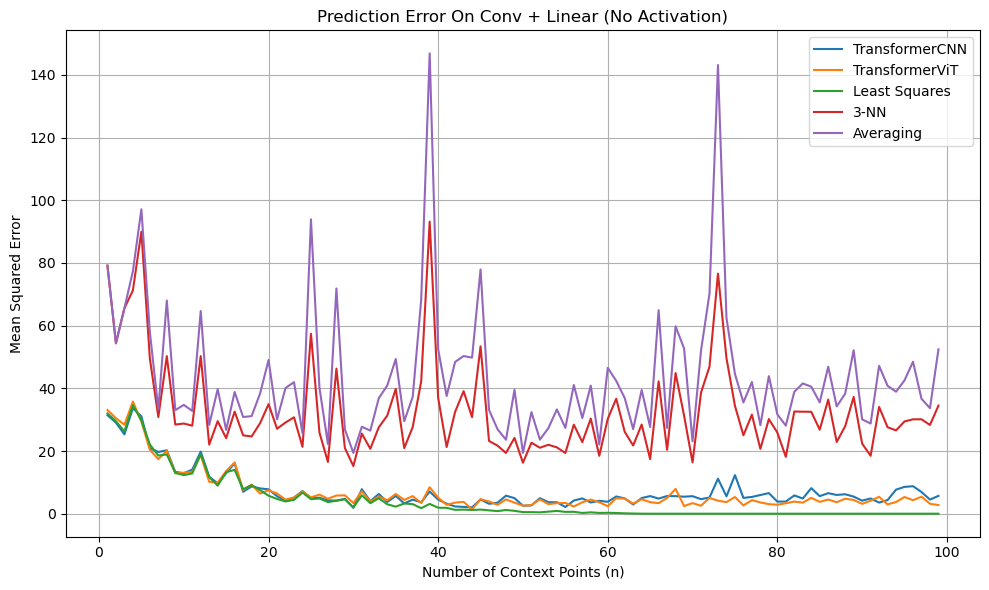

In [ ]:
import matplotlib.pyplot as plt

n_vals = list(range(1, max_context))

plt.figure(figsize=(10, 6))
for method, err_list in errors.items():
    plt.plot(n_vals, err_list, label=method)

plt.title("Prediction Error On Conv + Linear (No Activation)")
plt.xlabel("Number of Context Points (n)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
def generate_conv_task(n, image_size=8):
    conv = SimpleCNN(image_size)
    
    x_ctx = sample_cifar_mini(n)
    y_ctx = conv(x_ctx)

    x_query = sample_cifar_mini(1)
    y_true = conv(x_query)

    return x_ctx.view(-1, image_size ** 2), y_ctx.detach(), x_query.view(-1, image_size ** 2), y_true.detach()

In [24]:
errors = {"Transformer From CNN": [], "Transformer From ViT": [], "Least Squares": [], "3-NN": [], "Averaging": []}

max_context = 100
average_over = 32

for n in range(1, max_context):
    err_t1 = err_t2 = err_ls = err_knn = err_avg = 0
    for _ in range(average_over):
        x_ctx, y_ctx, x_query, y_true = generate_conv_task(n)

        x_input, y_input = make_transformer_input(x_ctx, y_ctx, x_query)
        x_input = x_input.to(device)
        y_input = y_input.to(device)

        with torch.no_grad():
            y_pred1 = model3(x_input, y_input)
            y_pred2 = model4(x_input, y_input)

        err_t1 += ((y_pred1.squeeze()[-1] - y_true.to(device)) ** 2).item()
        err_t2 += ((y_pred2.squeeze()[-1] - y_true.to(device)) ** 2).item()
        
        X = torch.cat([x_ctx, torch.ones_like(x_ctx)], dim=0)
        res = torch.linalg.lstsq(x_ctx, y_ctx)
        beta = res.solution
        y_ls = x_query @ beta
        err_ls += ((y_ls - y_true) ** 2).item()

        dists = torch.abs(x_ctx - x_query)
        _, idxs = torch.topk(dists, min(3, len(x_ctx)), largest=False, dim=0)
        y_knn = y_ctx[idxs].mean()
        err_knn += ((y_knn - y_true)**2).item()

        y_avg = y_ctx.mean()
        err_avg += ((y_avg - y_true)**2).item()

    errors["Transformer From CNN"].append(err_t1 / average_over)
    errors["Transformer From ViT"].append(err_t2 / average_over)
    errors["Least Squares"].append(err_ls / average_over)
    errors["3-NN"].append(err_knn / average_over)
    errors["Averaging"].append(err_avg / average_over)


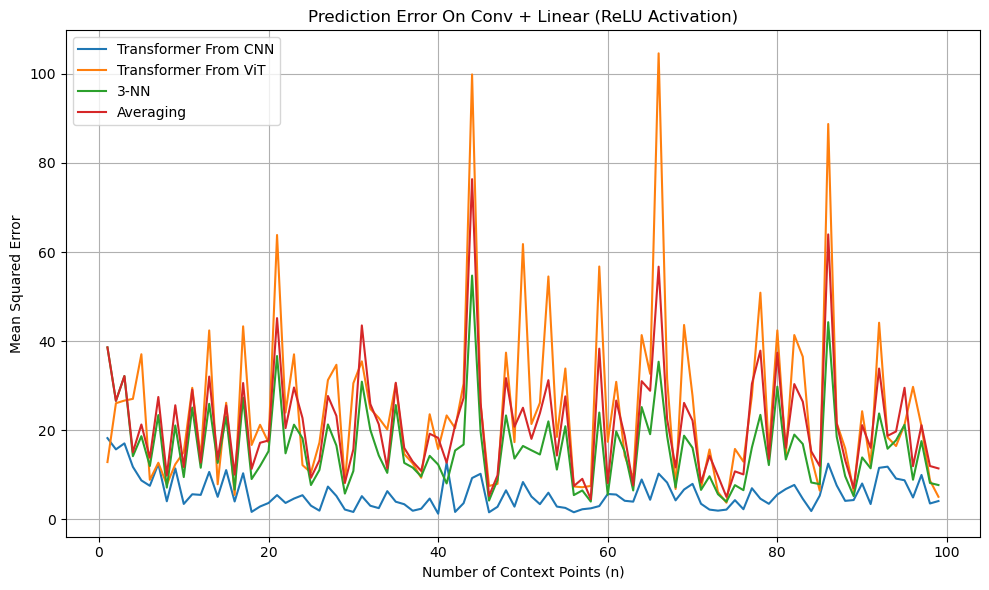

In [27]:
import matplotlib.pyplot as plt

n_vals = list(range(1, max_context))

plt.figure(figsize=(10, 6))
for method, err_list in errors.items():
    if method != 'Least Squares':
        plt.plot(n_vals, err_list, label=method)

plt.title("Prediction Error On Conv + Linear (ReLU Activation)")
plt.xlabel("Number of Context Points (n)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def generate_vit_task(n, image_size=8):
    vit = SimplerViT(image_size)
    
    x_ctx = sample_cifar_mini(n)
    y_ctx = vit(x_ctx)

    x_query = sample_cifar_mini(1)
    y_true = vit(x_query)

    return x_ctx.view(-1, image_size ** 2), y_ctx.detach(), x_query.view(-1, image_size ** 2), y_true.detach()

In [29]:
errors = {"Transformer From CNN": [], "Transformer From ViT": [], "Least Squares": [], "3-NN": [], "Averaging": []}

max_context = 100
average_over = 32

for n in range(1, max_context):
    err_t1 = err_t2 = err_ls = err_knn = err_avg = 0
    for _ in range(average_over):
        x_ctx, y_ctx, x_query, y_true = generate_vit_task(n)

        x_input, y_input = make_transformer_input(x_ctx, y_ctx, x_query)
        x_input = x_input.to(device)
        y_input = y_input.to(device)

        with torch.no_grad():
            y_pred1 = model3(x_input, y_input)
            y_pred2 = model4(x_input, y_input)

        err_t1 += ((y_pred1.squeeze()[-1] - y_true.to(device)) ** 2).item()
        err_t2 += ((y_pred2.squeeze()[-1] - y_true.to(device)) ** 2).item()
        
        X = torch.cat([x_ctx, torch.ones_like(x_ctx)], dim=0)
        res = torch.linalg.lstsq(x_ctx, y_ctx)
        beta = res.solution
        y_ls = x_query @ beta
        err_ls += ((y_ls - y_true) ** 2).item()

        dists = torch.abs(x_ctx - x_query)
        _, idxs = torch.topk(dists, min(3, len(x_ctx)), largest=False, dim=0)
        y_knn = y_ctx[idxs].mean()
        err_knn += ((y_knn - y_true)**2).item()

        y_avg = y_ctx.mean()
        err_avg += ((y_avg - y_true)**2).item()

    errors["Transformer From CNN"].append(err_t1 / average_over)
    errors["Transformer From ViT"].append(err_t2 / average_over)
    errors["Least Squares"].append(err_ls / average_over)
    errors["3-NN"].append(err_knn / average_over)
    errors["Averaging"].append(err_avg / average_over)


/home/antony/anaconda3/envs/cs182/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


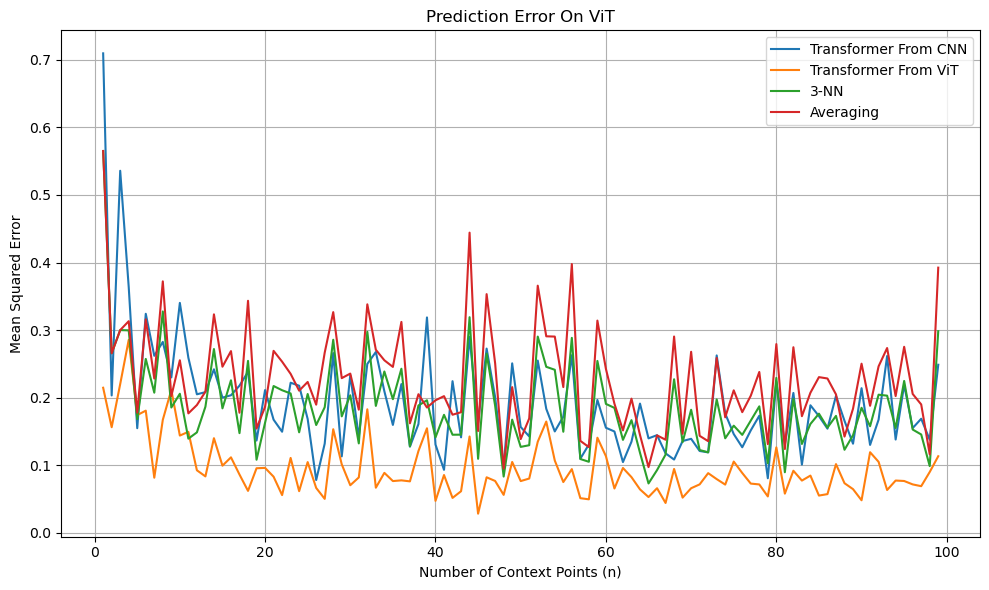

In [31]:
import matplotlib.pyplot as plt

n_vals = list(range(1, max_context))

plt.figure(figsize=(10, 6))
for method, err_list in errors.items():
    if method != 'Least Squares':
        plt.plot(n_vals, err_list, label=method)

plt.title("Prediction Error On ViT")
plt.xlabel("Number of Context Points (n)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
def train_mlp(x_ctx, y_ctx, lr=1e-3, num_epochs=5000):
    mlp = SimpleMLP().to(device)
    opt = torch.optim.Adam(mlp.parameters(), lr)
    x_ctx = x_ctx.to(device)
    y_ctx = y_ctx.to(device)
    for _ in range(num_epochs):
        y_preds = mlp(x_ctx)
        loss = F.mse_loss(y_preds, y_ctx)
        opt.zero_grad()
        loss.backward()
        opt.step()
    return mlp
    

def train_cnn(x_ctx, y_ctx, lr=1e-3, num_epochs=5000):
    cnn = SimpleCNN().to(device)
    opt = torch.optim.Adam(cnn.parameters(), lr)
    x_ctx = x_ctx.to(device)
    y_ctx = y_ctx.to(device)
    for _ in range(num_epochs):
        y_preds = cnn(x_ctx)
        loss = F.mse_loss(y_preds, y_ctx)
        opt.zero_grad()
        loss.backward()
        opt.step()
    return cnn

def train_vit(x_ctx, y_ctx, lr=1e-3, num_epochs=5000):
    vit = SimplerViT().to(device)
    opt = torch.optim.Adam(vit.parameters(), lr)
    x_ctx = x_ctx.to(device)
    y_ctx = y_ctx.to(device)
    for _ in range(num_epochs):
        y_preds = vit(x_ctx)
        loss = F.mse_loss(y_preds, y_ctx)
        opt.zero_grad()
        loss.backward()
        opt.step()
    return vit

In [34]:
errors = {"Transformer From CNN": [], "MLP": [], "CNN": [], "ViT": []}

max_context = 100
average_over = 5

for n in range(1, max_context + 1, 4):
    print(n)
    err_t = err_m = err_c = err_v = 0
    for _ in range(average_over):
        x_ctx, y_ctx, x_query, y_true = generate_conv_task(n)

        x_input, y_input = make_transformer_input(x_ctx, y_ctx, x_query)
        x_input = x_input.to(device)
        y_input = y_input.to(device)

        with torch.no_grad():
            y_pred1 = model3(x_input, y_input)

        err_t += ((y_pred1.squeeze()[-1] - y_true.to(device)) ** 2).item()
        
        mlp = train_mlp(x_ctx, y_ctx)
        y_pred2 = mlp(x_query.to(device)).cpu()
        err_m += ((y_pred2.squeeze() - y_true.to(device)) ** 2).item()
        
        cnn = train_cnn(x_ctx.view(n, 1, 8, 8), y_ctx)
        y_pred3 = cnn(x_query.view(1, 1, 8, 8).to(device)).cpu()
        err_c += ((y_pred3.squeeze() - y_true.to(device)) ** 2).item()
        
        vit = train_vit(x_ctx.view(n, 1, 8, 8), y_ctx)
        y_pred4 = vit(x_query.view(1, 1, 8, 8).to(device)).cpu()
        err_v += ((y_pred4.squeeze() - y_true.to(device)) ** 2).item()
        

    errors["Transformer From CNN"].append(err_t / average_over)
    errors["MLP"].append(err_m / average_over)
    errors["CNN"].append(err_c / average_over)
    errors["ViT"].append(err_v / average_over)


1
5
9
13
17
21
25
29
33
37
41
45
49
53
57
61
65
69
73
77
81
85
89
93
97


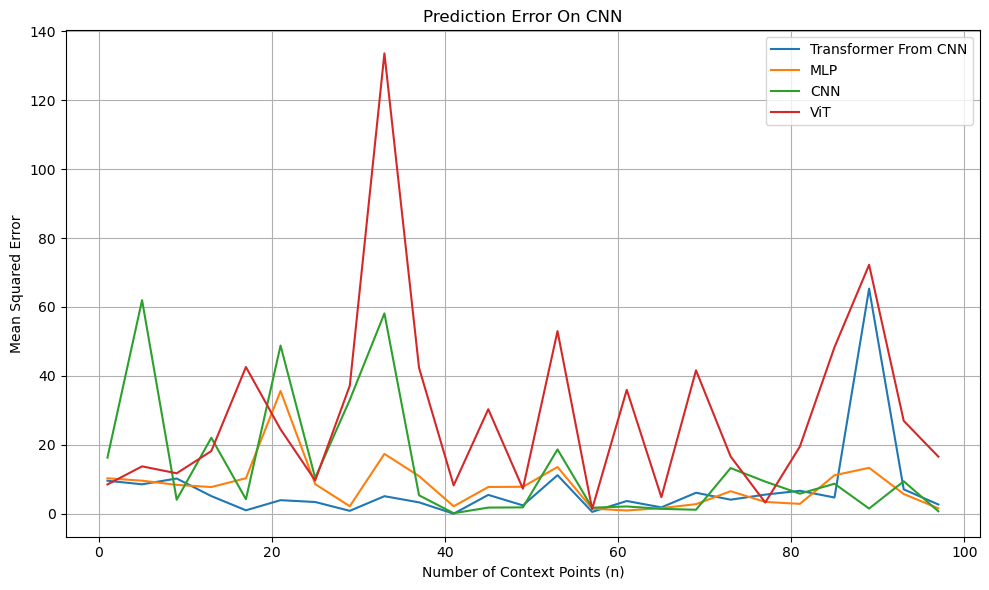

In [35]:
import matplotlib.pyplot as plt

n_vals = list(range(1, max_context + 1, 4))

plt.figure(figsize=(10, 6))
for method, err_list in errors.items():
    plt.plot(n_vals, err_list, label=method)

plt.title("Prediction Error On CNN")
plt.xlabel("Number of Context Points (n)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
errors = {"Transformer From ViT": [], "MLP": [], "CNN": [], "ViT": []}

max_context = 100
average_over = 10

for n in range(1, max_context + 1, 5):
    print(n)
    err_t = err_m = err_c = err_v = 0
    for _ in range(average_over):
        x_ctx, y_ctx, x_query, y_true = generate_vit_task(n)

        x_input, y_input = make_transformer_input(x_ctx, y_ctx, x_query)
        x_input = x_input.to(device)
        y_input = y_input.to(device)

        with torch.no_grad():
            y_pred1 = model4(x_input, y_input)

        err_t += ((y_pred1.squeeze()[-1] - y_true.to(device)) ** 2).item()
        
        mlp = train_mlp(x_ctx, y_ctx)
        y_pred2 = mlp(x_query.to(device)).cpu()
        err_m += ((y_pred2.squeeze() - y_true.to(device)) ** 2).item()
        
        cnn = train_cnn(x_ctx.view(n, 1, 8, 8), y_ctx)
        y_pred3 = cnn(x_query.view(1, 1, 8, 8).to(device)).cpu()
        err_c += ((y_pred3.squeeze() - y_true.to(device)) ** 2).item()
        
        vit = train_vit(x_ctx.view(n, 1, 8, 8), y_ctx)
        y_pred4 = vit(x_query.view(1, 1, 8, 8).to(device)).cpu()
        err_v += ((y_pred4.squeeze() - y_true.to(device)) ** 2).item()
        

    errors["Transformer From ViT"].append(err_t / average_over)
    errors["MLP"].append(err_m / average_over)
    errors["CNN"].append(err_c / average_over)
    errors["ViT"].append(err_v / average_over)


1
6
11
16
21
26
31
36
41
46
51
56


KeyboardInterrupt: 

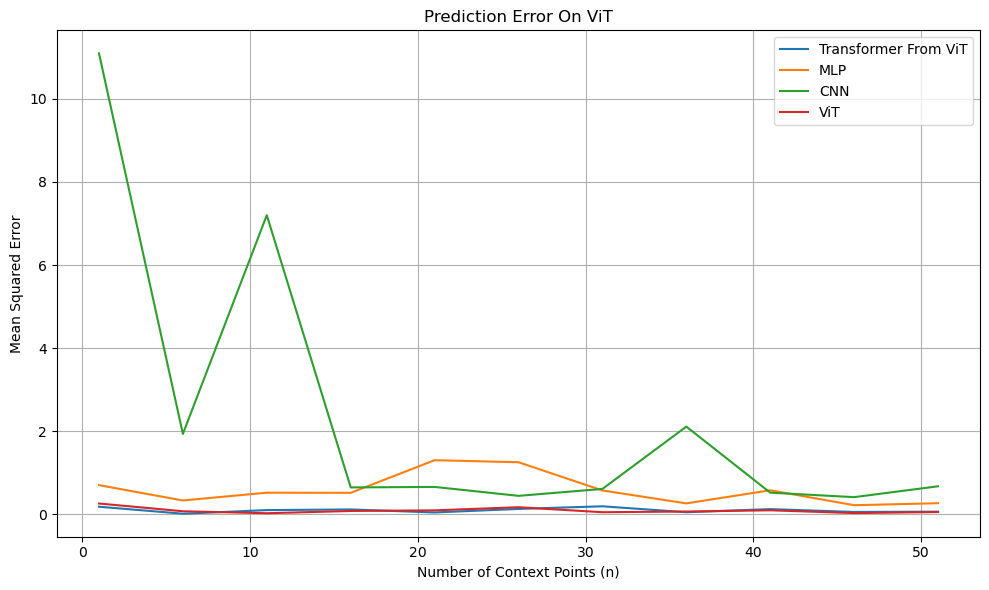

In [38]:
import matplotlib.pyplot as plt

n_vals = list(range(1, 55 + 1, 5))

plt.figure(figsize=(10, 6))
for method, err_list in errors.items():
    plt.plot(n_vals, err_list, label=method)

plt.title("Prediction Error On ViT")
plt.xlabel("Number of Context Points (n)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()